<a href="https://colab.research.google.com/github/aidargtd/Library_System-QtProject/blob/master/psb_hack_reg_class_using.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Поле для размышлений

- парсинг погоды
- начало сво
- взрывы в крыму
https://secretmag.ru/survival/mozhno-li-besplatno-otmenit-bron-v-krym-posle-terakta-na-krymskom-mostu-otvechayut-otelery-17-07-2023.htm -- на первом графике заметен скачок в июле-августе, когда произошел взрыв на крымском мосту

- (поиск событий по датам, которые могут повлиять)
- сезонность туризма в данном регионе
-ноовый год самая высокая доля отмен
-закрытие аэропортов
- "там когда пригожина ебнули"
-моменты мобилизации
-сочи адлер наводнение и шторм был в 2023 в июле

-видимо 4 регион самый безопасный

2 и 3 сильно похожи, скорее всего, где больше пиздеца по графику, это будет Крым
мы хоть понимаем что юг разве нет? на границе с укр

-диверсия на сеерный поток2022 09
- скачки доллара
- введение санкций ес

MAIN TASK --  разработка банковского продукта для студентов и людям от 18-30.

Feature Tools - я видел вчера, что ее используют для автоматической генерации признаков. вдруг что-то годное даст

парсинг погоды тоже бы узнать как делать, зная дату и город. брать среднююю температуру за период пребывания в городе. у меня просто сейчас идеи в голове, я их пишу чтобы не потерялись

In [73]:
!pip install featuretools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 13.7 MB/s eta 0:00:00


In [4]:
!pip install openpyxl catboost >> None

In [61]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
import os
import random
import torch
import tensorflow as tf


DEFAULT_RANDOM_SEED = 42


def set_all_seeds(seed=DEFAULT_RANDOM_SEED):

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # tensorflow's seed
    tf.random.set_seed(seed)


set_all_seeds(seed=DEFAULT_RANDOM_SEED)

Заново подгрузил датасет, чтобы поработать с данными об отмене


In [10]:
# таблица исходных данных
data = pd.read_excel('train.xlsx')
data.sample(5)

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
5405,5405,20220528-7492-138788495,1,13900.0,13900,Банк. карта: Банк Россия (банк. карта),2022-05-17 11:23:03,NaT,2022-05-28 15:00:00,1,2022-05-29 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2
20995,20995,20230422-6634-194456593,1,8700.0,0,При заселении,2023-04-19 09:32:46,NaT,2023-04-22 15:00:00,1,2023-04-23 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
15439,15439,20230817-7491-215993147,1,28800.0,28800,Банк. карта: Банк Россия (банк. карта),2023-08-04 00:47:36,NaT,2023-08-17 15:00:00,2,2023-08-19 12:00:00,Программа лояльности,Активный,Номер «Стандарт»,2,3
19500,19500,20230815-16563-204151798,1,23200.0,23200,Банк. карта: Банк Россия (банк. карта),2023-06-10 19:41:15,NaT,2023-08-15 15:00:00,1,2023-08-16 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4
17112,17112,20220829-7492-157375032,1,13900.0,13900,Отложенная электронная оплата: Банк Россия (ба...,2022-08-22 11:12:58,NaT,2022-08-29 15:00:00,1,2022-08-30 12:00:00,Бронирование из экстранета,Активный,Номер «Стандарт»,2,2


In [11]:
data['Категория номера'].value_counts()

,count
Категория номера,
Номер «Стандарт»,16872
Номер «Студия»,4929
Апартаменты с 2 спальнями с отдельным входом,1957
Номер «Люкс»,759
Коттедж с 2 спальнями,720
Коттедж с 3 спальнями,676
1. Номер «Стандарт»\n2. Номер «Стандарт»,158
Номер «Стандарт» для маломобильных групп населения,25
1. Номер «Стандарт»\n2. Номер «Стандарт»\n3. Номер «Стандарт»,17


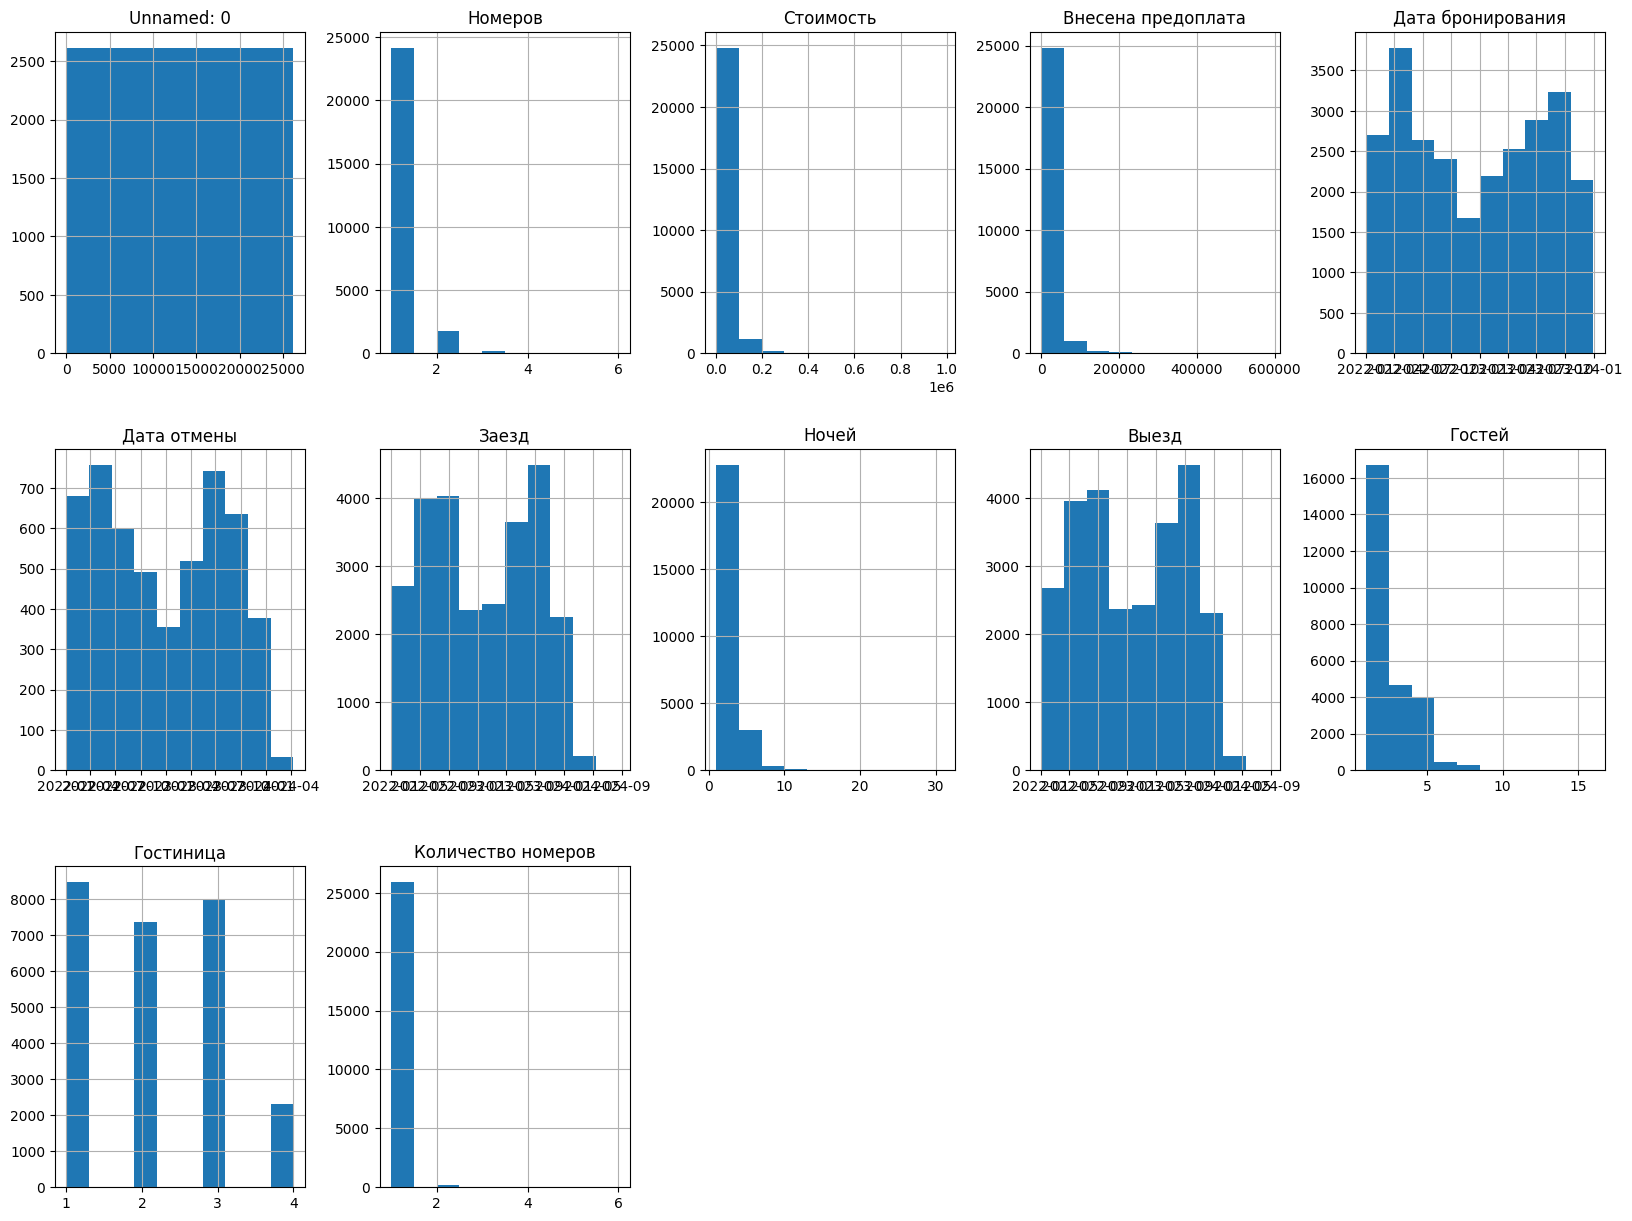

In [13]:
data.hist(figsize=(20, 15), layout=(-1, 5));

In [14]:
data["№ брони"].value_counts().max()

1

<ipython-input-15-76b67c3deb27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canceled['Месяц отмены'] = df_canceled['Дата отмены'].dt.to_period('M').astype(str)


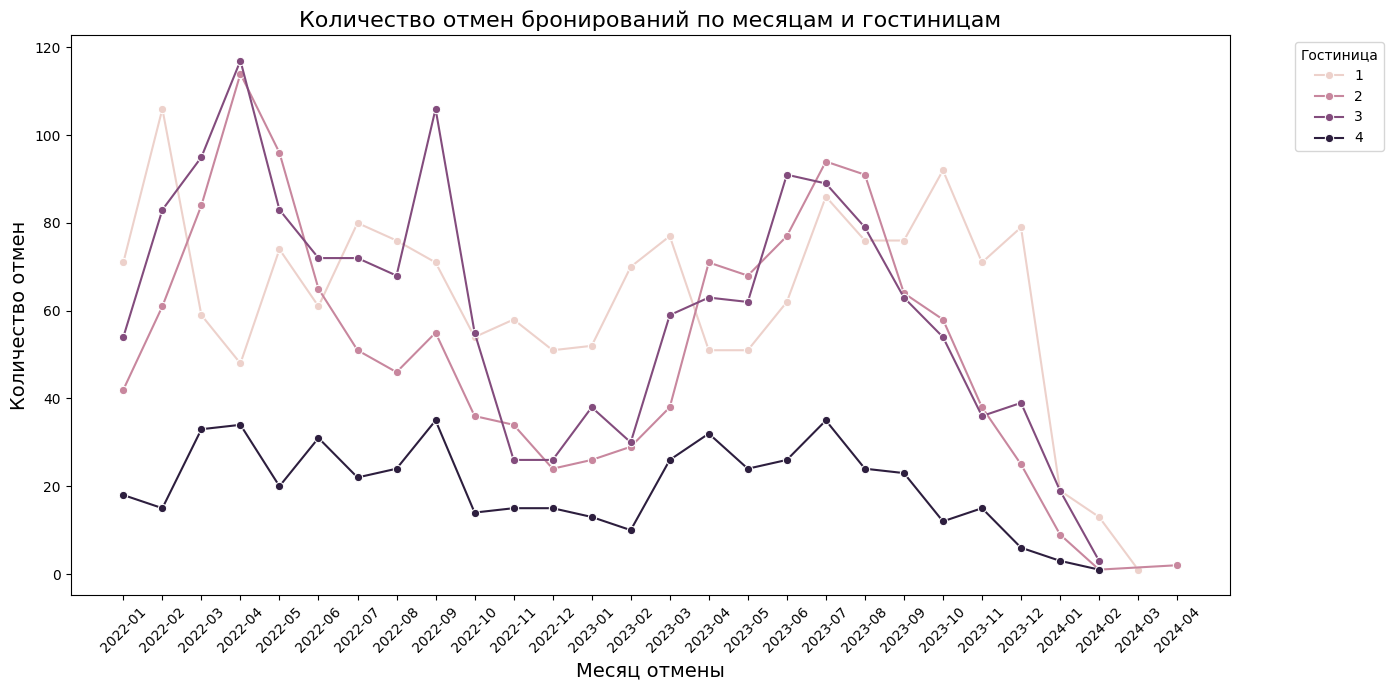

In [15]:
df_canceled = data.dropna(subset=['Дата отмены'])
df_canceled.sample(5)
df_canceled['Месяц отмены'] = df_canceled['Дата отмены'].dt.to_period('M').astype(str)

cancellations_per_month_hotel = df_canceled.groupby(['Месяц отмены', 'Гостиница']).size().reset_index(name='Количество отмен')

# 6. Создаём график с параметром hue
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=cancellations_per_month_hotel,
    x='Месяц отмены',
    y='Количество отмен',
    hue='Гостиница',
    marker='o'
)

# Добавляем заголовок и метки осей
plt.title('Количество отмен бронирований по месяцам и гостиницам', fontsize=16)
plt.xlabel('Месяц отмены', fontsize=14)
plt.ylabel('Количество отмен', fontsize=14)

# Улучшаем отображение меток по оси X
plt.xticks(rotation=45)

# Перемещаем легенду за пределы графика для лучшей читаемости
plt.legend(title='Гостиница', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Отображаем график
plt.show()


долю отмен бронирований от общего количества бронирований для каждого региона в зависимости от даты. Это позволит вам увидеть тенденции отмен по регионам во времени.

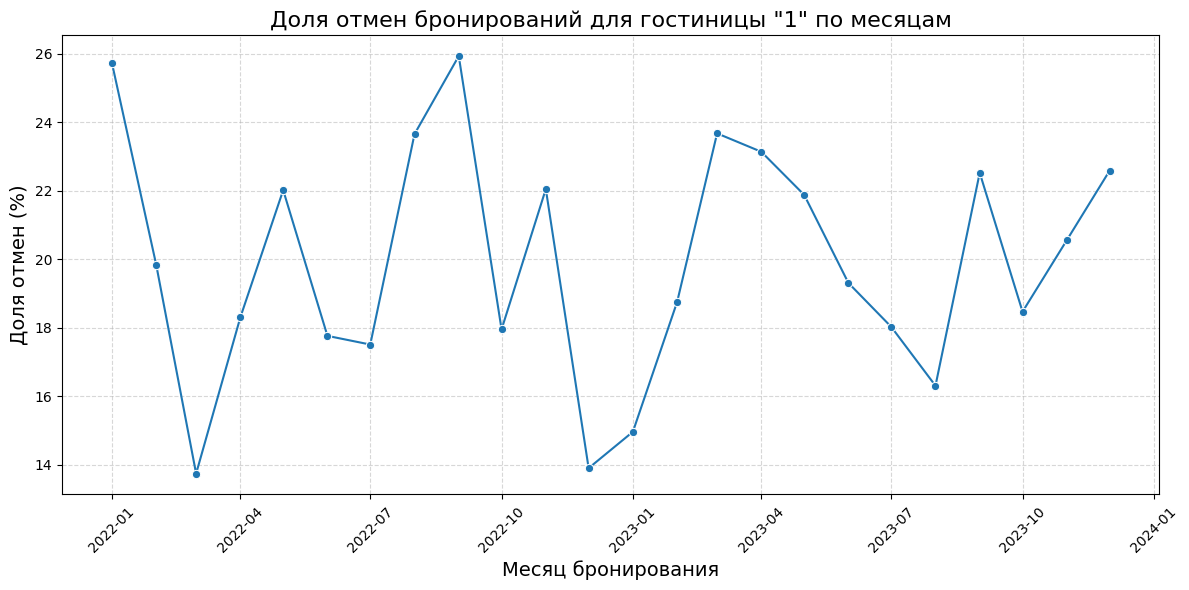

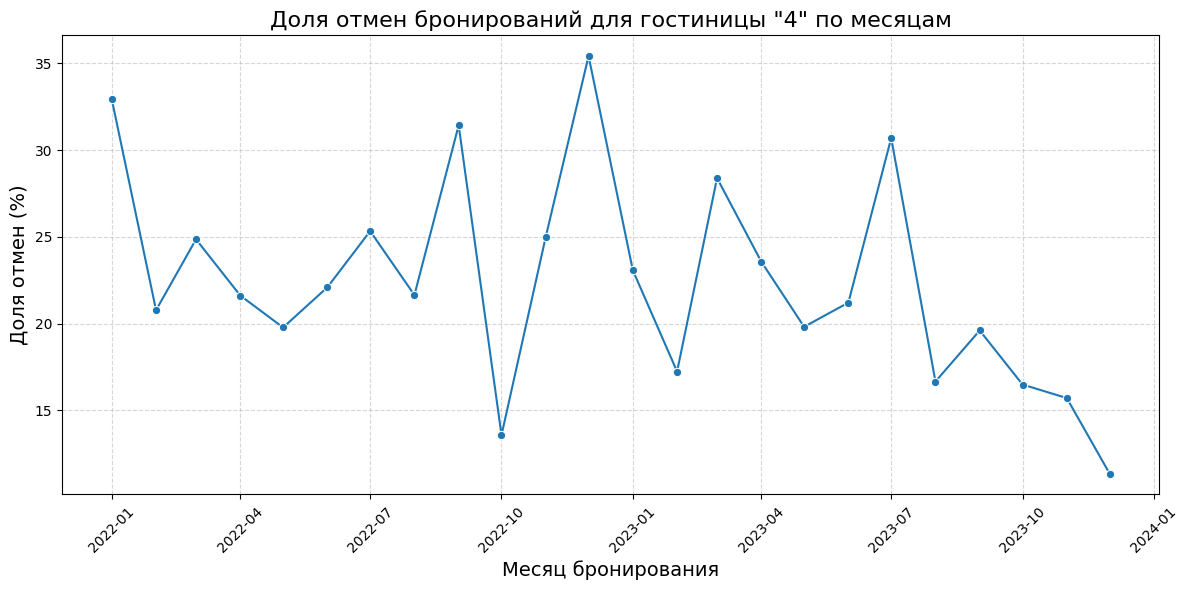

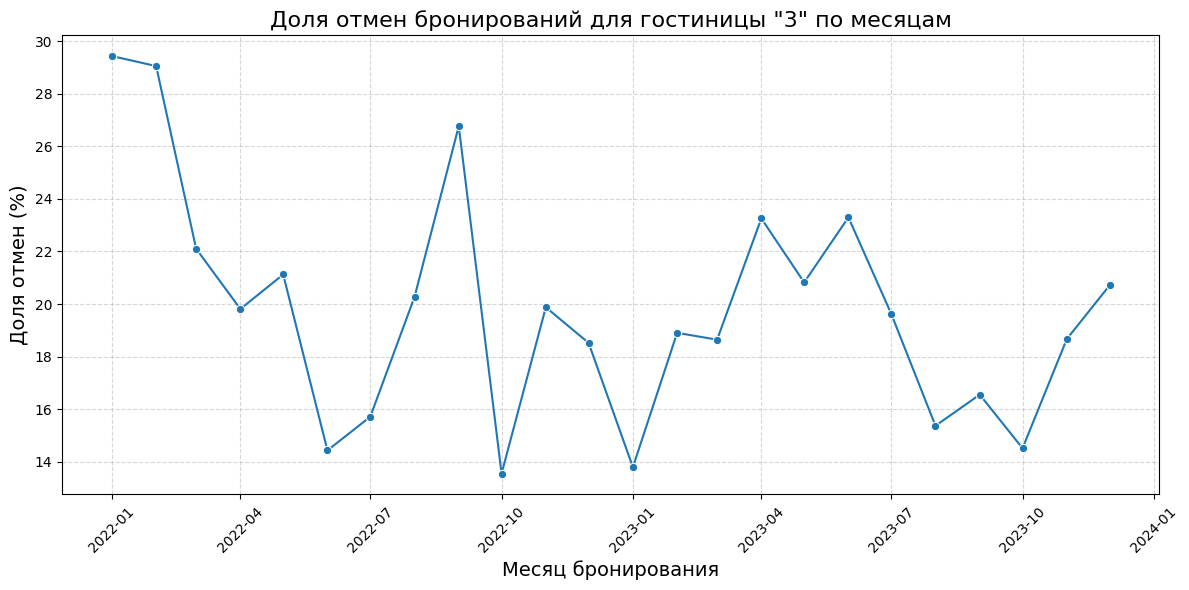

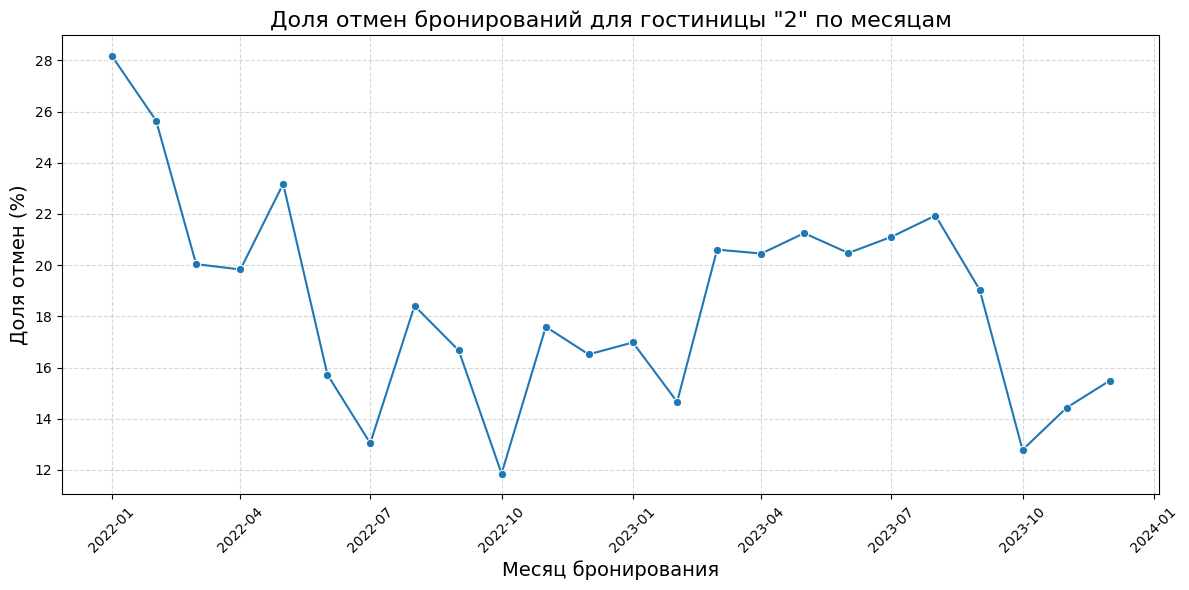

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предположим, что ваш DataFrame называется df и уже загружен
# Например:
# df = pd.read_csv('your_data.csv')

# 1. Преобразуем столбцы с датами в тип datetime
data['Дата бронирования'] = pd.to_datetime(data['Дата бронирования'], errors='coerce')
data['Дата отмены'] = pd.to_datetime(data['Дата отмены'], errors='coerce')

# 2. Создаём бинарный признак отмены
data['Отменено'] = data['Дата отмены'].notna().astype(int)

# 3. Создаём новый столбец для месяца бронирования
data['Месяц бронирования'] = data['Дата бронирования'].dt.to_period('M').dt.to_timestamp()

# 4. Получаем список уникальных гостиниц (предполагаем, что их 4)
hotels = data['Гостиница'].unique()

# Проверяем, что у нас ровно 4 гостиницы
if len(hotels) != 4:
    print(f"Обнаружено {len(hotels)} гостиниц. Ожидалось 4.")
else:
    # 5. Создаём отдельные графики для каждой гостиницы
    for hotel in hotels:
        # Фильтруем данные для текущей гостиницы
        df_hotel = data[data['Гостиница'] == hotel]

        # Группируем по месяцу бронирования
        grouped = df_hotel.groupby('Месяц бронирования').agg(
            Общее_бронирований=('№ брони', 'count'),
            Отменено_бронирований=('Отменено', 'sum')
        ).reset_index()

        # Вычисляем долю отмен
        grouped['Доля отмен (%)'] = (grouped['Отменено_бронирований'] / grouped['Общее_бронирований']) * 100

        # Создаём график
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=grouped,
            x='Месяц бронирования',
            y='Доля отмен (%)',
            marker='o'
        )

        # Настраиваем заголовок и метки осей
        plt.title(f'Доля отмен бронирований для гостиницы "{hotel}" по месяцам', fontsize=16)
        plt.xlabel('Месяц бронирования', fontsize=14)
        plt.ylabel('Доля отмен (%)', fontsize=14)

        # Форматируем ось X для лучшей читаемости
        plt.xticks(rotation=45)

        # Добавляем сетку
        plt.grid(True, linestyle='--', alpha=0.5)

        # Автоматическая подгонка элементов графика
        plt.tight_layout()

        # Сохраняем график в файл (опционально)
        # plt.savefig(f'delivery_rate_{hotel}.png', dpi=300, bbox_inches='tight')

        # Отображаем график
        plt.show()


In [19]:
#статус брони
data["Статус брони"].value_counts()

,count
Статус брони,
Активный,20978
Отмена,3403
Неподтвержденные,1787
Ожидается оплата,4
Освоб. заранее,2


In [20]:
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test.xlsx')
train_data.sample(5)

# Исключение столбца 'Статус брони' из данных
if 'Статус брони' in train_data.columns:
    train_data = train_data.drop(columns=['Статус брони', 'Unnamed: 0'])
if 'Unnamed: 0' in test_data.columns:
    test_data = test_data.drop(columns=['Unnamed: 0'])



In [21]:
if "№ брони" in train_data.columns:
    train_data.drop(columns=['№ брони'], inplace=True)
if "№ брони" in test_data.columns:
    test_data.drop(columns=['№ брони'], inplace=True)
train_data.sample(5)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
24988,1,38300.0,38300,Банк. карта: Банк Россия (банк. карта),2022-07-07 10:00:45,NaT,2022-07-15 15:00:00,1,2022-07-16 12:00:00,Официальный сайт,Коттедж с 2 спальнями,2,1
11113,1,18100.0,9900,Банк. карта: Банк Россия (банк. карта),2023-03-19 14:20:59,NaT,2023-05-01 15:00:00,2,2023-05-03 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
17347,1,28800.0,0,Отложенная электронная оплата: Банк Россия (ба...,2023-08-08 14:28:51,2023-08-09 02:28:39,2023-08-26 15:00:00,2,2023-08-28 12:00:00,Официальный сайт,Номер «Стандарт»,3,3
18078,1,180900.0,180900,Банк. карта: Банк Россия (банк. карта),2022-12-14 21:27:47,NaT,2022-12-25 15:00:00,5,2022-12-30 12:00:00,Официальный сайт,Коттедж с 2 спальнями,3,1
18425,1,88240.0,0,Отложенная электронная оплата: Банк Россия (ба...,2023-01-25 00:24:10,2023-01-25 12:28:35,2023-02-10 15:00:00,7,2023-02-17 12:00:00,Бронирование из экстранета,Номер «Студия»,2,2


In [26]:
train_date_columns = ['Дата бронирования', 'Дата отмены', 'Заезд', 'Выезд']
test_date_columns = ['Дата бронирования', 'Заезд', 'Выезд']

for col in train_date_columns:
    train_data[col] = pd.to_datetime(train_data[col], errors='coerce')

for col in test_date_columns:
    test_data[col] = pd.to_datetime(test_data[col], errors='coerce')


In [32]:
train_data['Отмена'] = train_data['Дата отмены'].notnull().astype(int)
data['Отмена'] = data['Дата отмены'].notnull().astype(int)

In [33]:
train_data.head()

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,Отмена
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1,1
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1,0
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,2,4,0
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,NaT,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,1,3,0
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,NaT,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1,0


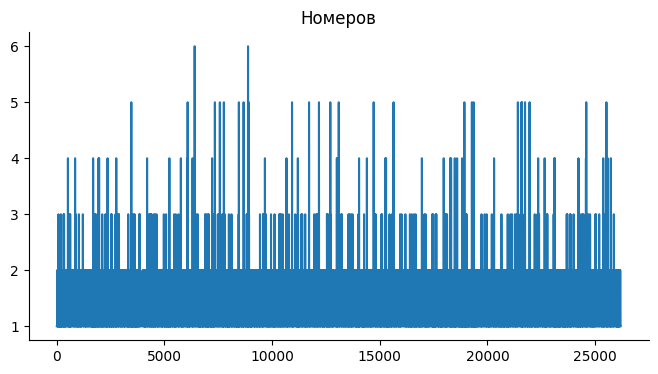

In [30]:
# @title Номеров

from matplotlib import pyplot as plt
train_data['Номеров'].plot(kind='line', figsize=(8, 4), title='Номеров')
plt.gca().spines[['top', 'right']].set_visible(False)

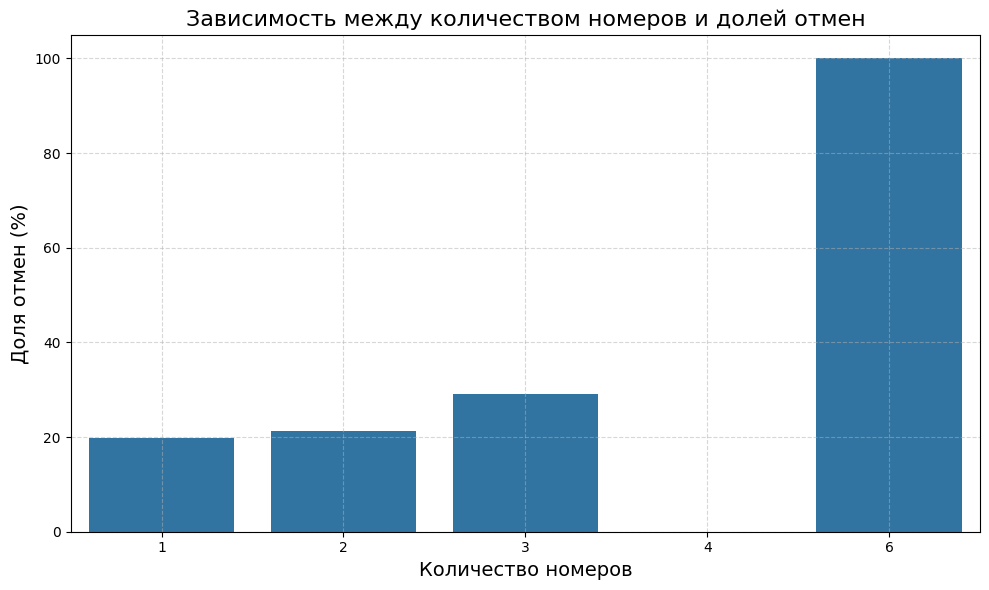

In [34]:
data['Количество номеров'] = data['Категория номера'].apply(lambda x: len(x.split('\n')))

# 2. Группируем данные по количеству номеров и считаем общие бронирования и количество отмен
grouped = data.groupby('Количество номеров').agg(
    Общее_бронирований=('Отмена', 'count'),
    Отменено_бронирований=('Отмена', 'sum')
).reset_index()

# 3. Вычисляем долю отмен
grouped['Доля отмен (%)'] = (grouped['Отменено_бронирований'] / grouped['Общее_бронирований']) * 100

# 4. Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='Количество номеров', y='Доля отмен (%)')

# Настройка графика
plt.title('Зависимость между количеством номеров и долей отмен', fontsize=16)
plt.xlabel('Количество номеров', fontsize=14)
plt.ylabel('Доля отмен (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [35]:
def extract_date_features(df, is_train=True):
    df['День бронирования'] = df['Дата бронирования'].dt.day
    df['Месяц бронирования'] = df['Дата бронирования'].dt.month
    df['День недели бронирования'] = df['Дата бронирования'].dt.weekday
    df['Количество номеров'] = df['Категория номера'].apply(lambda x: len(x.split('\n')) if pd.notnull(x) else 0)
    df['День заезда'] = df['Заезд'].dt.day
    df['Месяц заезда'] = df['Заезд'].dt.month
    df['День недели заезда'] = df['Заезд'].dt.weekday

    df['Количество дней'] = (df['Заезд'] - df['Дата бронирования']).dt.days
    df['prepayment_ratio'] = df['Внесена предоплата'] / df['Стоимость']
    df['guests_per_room'] = df['Гостей'] / df['Номеров']


    if is_train:
        # Дополнительные признаки для тренировочного набора, если необходимо
        pass

    return df


train_data = extract_date_features(train_data, is_train=True)
test_data = extract_date_features(test_data, is_train=False)


In [38]:
test_data.sample(10)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,...,День бронирования,Месяц бронирования,День недели бронирования,Количество номеров,День заезда,Месяц заезда,День недели заезда,Количество дней,prepayment_ratio,guests_per_room
4142,1,706230.0,41300,Банк. карта: Банк Россия (банк. карта),2022-04-19 15:52:24,2022-07-03 15:00:00,19,2022-07-22 12:00:00,Официальный сайт,Коттедж с 2 спальнями,...,19,4,1,1,3,7,6,74,0.058480,4.0
1430,1,16400.0,0,Внешняя система оплаты (С предоплатой),2023-12-25 19:54:13,2024-01-02 15:00:00,1,2024-01-03 12:00:00,ostrovok.ru,Номер «Стандарт»,...,25,12,0,1,2,1,1,7,0.000000,2.0
4542,1,22040.0,10830,Банк. карта: Банк Россия (банк. карта),2022-12-23 15:54:40,2022-12-27 15:00:00,2,2022-12-29 12:00:00,Официальный сайт,Номер «Стандарт»,...,23,12,4,1,27,12,1,3,0.491379,4.0
10329,1,64800.0,64800,Внешняя система оплаты (С предоплатой),2023-09-20 18:55:21,2023-10-09 15:00:00,4,2023-10-13 12:00:00,Яндекс.Путешествия,Номер «Студия»,...,20,9,2,1,9,10,0,18,1.000000,4.0
8184,1,49400.0,0,Внешняя система оплаты (С предоплатой),2023-10-24 01:41:11,2023-11-02 15:00:00,2,2023-11-04 12:00:00,ostrovok.ru,Апартаменты с 2 спальнями с отдельным входом,...,24,10,1,1,2,11,3,9,0.000000,4.0
4647,1,16200.0,16200,Банк. карта: Банк Россия (банк. карта),2023-03-03 22:31:48,2023-03-04 15:00:00,1,2023-03-05 12:00:00,Официальный сайт,Номер «Стандарт»,...,3,3,4,1,4,3,5,0,1.000000,2.0
1424,1,17400.0,17400,Отложенная электронная оплата: Банк Россия (ба...,2023-06-22 23:49:25,2023-07-15 15:00:00,1,2023-07-16 12:00:00,Официальный сайт,Номер «Люкс»,...,22,6,3,1,15,7,5,22,1.000000,3.0
1021,1,303200.0,0,Отложенная электронная оплата: Банк Россия (ба...,2023-01-08 17:59:19,2023-02-18 15:00:00,6,2023-02-24 12:00:00,Официальный сайт,Коттедж с 3 спальнями,...,8,1,6,1,18,2,5,40,0.000000,6.0
5500,1,41490.0,67230,Банк. карта: Банк Россия (банк. карта),2023-05-02 13:17:19,2023-08-20 15:00:00,3,2023-08-23 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,...,2,5,1,1,20,8,6,110,1.620390,4.0
6589,2,46000.0,22200,Банк. карта: Банк Россия (банк. карта),2023-07-06 15:43:49,2023-08-10 15:00:00,2,2023-08-12 12:00:00,Официальный сайт,1. Номер «Стандарт»\n2. Номер «Стандарт»,...,6,7,3,2,10,8,3,34,0.482609,2.0


In [39]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

test_data['booking_season'] = test_data['Месяц бронирования'].apply(get_season)
train_data['booking_season'] = train_data['Месяц бронирования'].apply(get_season)

In [40]:
# Список категориальных признаков
categorical_features = ['Способ оплаты', 'Источник', 'Категория номера', 'Гостиница', 'booking_season']

# Проверяем наличие пропущенных значений в категориальных признаках тестового набора
print("Пропущенные значения в категориальных признаках тестового набора:")
print(test_data[categorical_features].isnull().sum())


Пропущенные значения в категориальных признаках тестового набора:
Способ оплаты       0
Источник            0
Категория номера    0
Гостиница           0
booking_season      0
dtype: int64


In [41]:
# Заполнение пропущенных значений и преобразование в строку
for col in categorical_features:
    train_data[col] = train_data[col].astype(str).fillna('Missing')
    test_data[col] = test_data[col].astype(str).fillna('Missing')

In [42]:
numerical_features = ['Номеров', 'Стоимость', 'Внесена предоплата', 'Ночей', 'Гостей',
                      'День бронирования', 'Месяц бронирования', 'День недели бронирования',
                      'День заезда', 'Месяц заезда', 'День недели заезда',
                      'Количество дней', 'prepayment_ratio','guests_per_room','Количество номеров']


for col in numerical_features:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

    # Заполняем пропущенные значения медианой
    median = train_data[col].median()
    train_data[col].fillna(median, inplace=True)
    test_data[col].fillna(median, inplace=True)


In [43]:
features = numerical_features + categorical_features


## РАЗЛИЧНЫЕ ГРАФИКИ

sns.lmplot and displot

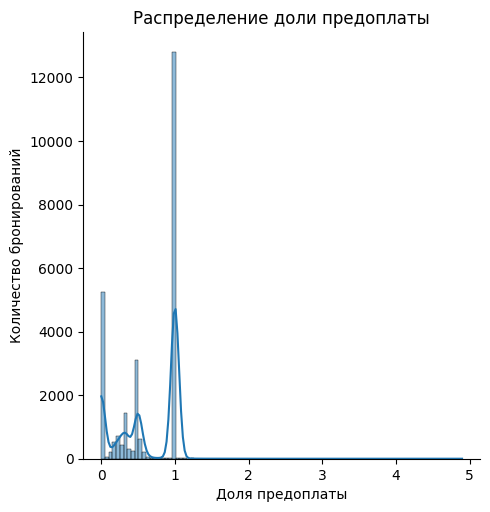

In [51]:
sns.displot(train_data['prepayment_ratio'].dropna(), kde=True)
plt.title('Распределение доли предоплаты')
plt.xlabel('Доля предоплаты')
plt.ylabel('Количество бронирований')
plt.show()


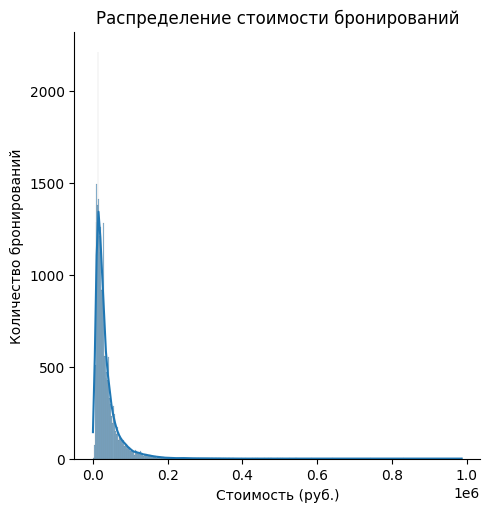

In [52]:
sns.displot(train_data['Стоимость'], kde=True)
plt.title('Распределение стоимости бронирований')
plt.xlabel('Стоимость (руб.)')
plt.ylabel('Количество бронирований')
plt.show()


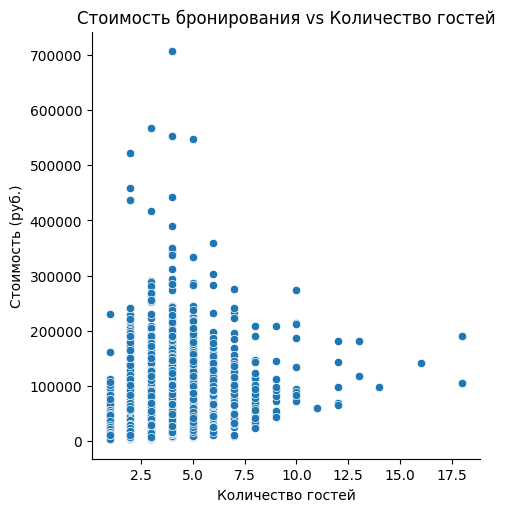

In [53]:
sns.relplot(x='Гостей', y='Стоимость', data=test_data)
plt.title('Стоимость бронирования vs Количество гостей')
plt.xlabel('Количество гостей')
plt.ylabel('Стоимость (руб.)')
plt.show()


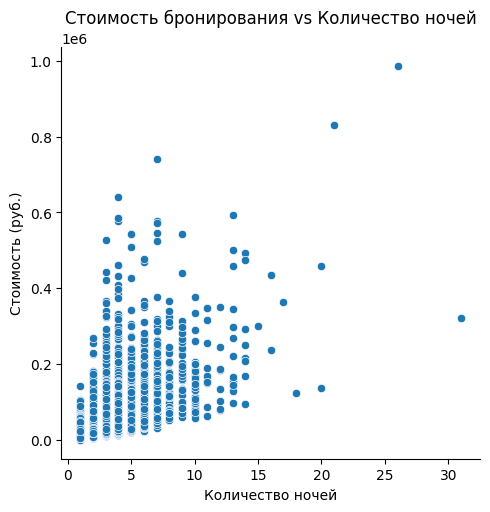

In [55]:
sns.relplot(x='Ночей', y='Стоимость', data=train_data)
plt.title('Стоимость бронирования vs Количество ночей')
plt.xlabel('Количество ночей')
plt.ylabel('Стоимость (руб.)')
plt.show()


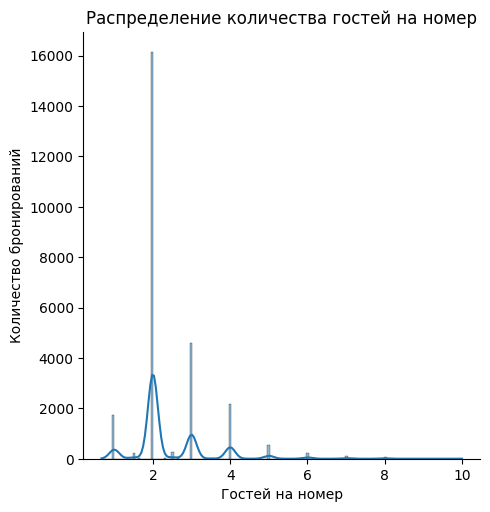

In [56]:
sns.displot(train_data['guests_per_room'].dropna(), kde=True)
plt.title('Распределение количества гостей на номер')
plt.xlabel('Гостей на номер')
plt.ylabel('Количество бронирований')
plt.show()


готовое решение на классифаере

In [ ]:
# X = train_data[features]
# y = train_data['Отмена']
# X_test = test_data[features]

# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Массив для хранения предсказаний на тестовом наборе
# test_preds = np.zeros(len(test_data))

# best_scores = []
# best_iterations = []

# for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
#     print(f'Фолд {fold + 1}/{n_splits}')
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     model = CatBoostClassifier(
#         iterations=1000,
#         learning_rate=0.05,
#         eval_metric='AUC',
#         random_seed=42,
#         verbose=100,
#         early_stopping_rounds=100,
#         cat_features=categorical_features
#     )

#     model.fit(
#         X_train, y_train,
#         eval_set=(X_val, y_val),
#         use_best_model=True,
#         verbose=False
#     )

#     # Сохранение лучшей метрики и итерации
#     best_score = model.best_score_['validation']['AUC']
#     best_iter = model.best_iteration_
#     best_scores.append(best_score)
#     best_iterations.append(best_iter)
#     print(f'Лучший AUC: {best_score} на итерации {best_iter}')

#     # Предсказание вероятностей
#     test_preds += model.predict_proba(X_test)[:, 1] / n_splits

Фолд 1/5
0:	test: 0.8251507	best: 0.8251507 (0)	total: 66.4ms	remaining: 1m 6s
100:	test: 0.8569043	best: 0.8569043 (100)	total: 2.51s	remaining: 22.3s
200:	test: 0.8583738	best: 0.8584164 (195)	total: 4.76s	remaining: 18.9s
300:	test: 0.8585024	best: 0.8585430 (297)	total: 7.04s	remaining: 16.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8585542765
bestIteration = 302

Shrink model to first 303 iterations.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [63]:
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f'Фолд {fold + 1}/{n_splits}')
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        random_seed=42,
        verbose=100,
        early_stopping_rounds=100,
        cat_features=categorical_features
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True,
        verbose=False
    )

    # Predict continuous values
    y_val_pred = model.predict(X_val)

    # Calculate AUC using predicted continuous values
    auc_score = roc_auc_score(y_val, y_val_pred)
    best_scores.append(auc_score)
    best_iterations.append(model.best_iteration_)
    print(f'Лучший AUC: {auc_score} на итерации {model.best_iteration_}')

    # Add the regression prediction for test data (no probabilities, just continuous prediction)
    test_preds += model.predict(X_test) / n_splits


Фолд 1/5
Лучший AUC: 0.8616614108858429 на итерации 428
Фолд 2/5
Лучший AUC: 0.8587452324088847 на итерации 583
Фолд 3/5
Лучший AUC: 0.8500148973278004 на итерации 480
Фолд 4/5
Лучший AUC: 0.8574653975704272 на итерации 188
Фолд 5/5
Лучший AUC: 0.864688316793129 на итерации 241


In [64]:
print(f'Средний лучший AUC: {np.mean(best_scores)}')

Средний лучший AUC: 0.8590420056832069


using classifier

In [65]:
# # Предсказание вероятностей на тестовом наборе
# test_data['Вероятность отмены'] = model.predict_proba(X_test)[:, 1]

AttributeError: 'CatBoostRegressor' object has no attribute 'predict_proba'

using regressor

In [67]:
test_data['Вероятность отмены'] = model.predict(X_test)

In [70]:
test_data.sample(10)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,...,День недели бронирования,Количество номеров,День заезда,Месяц заезда,День недели заезда,Количество дней,prepayment_ratio,guests_per_room,booking_season,Вероятность отмены
2057,1,19380.0,0,Отложенная электронная оплата: Банк Россия (ба...,2023-02-28 23:08:03,2023-03-19 15:00:00,2,2023-03-21 12:00:00,Официальный сайт,Номер «Стандарт»,...,1,1,19,3,6,18,0.0,1.0,Зима,0.957184
322,1,20800.0,10400,Банк. карта: Банк Россия (банк. карта),2022-06-22 18:15:45,2022-07-10 15:00:00,2,2022-07-12 12:00:00,Официальный сайт,Номер «Стандарт»,...,2,1,10,7,6,17,0.5,2.0,Лето,0.107802
8397,1,9800.0,9800,Банк. карта: Банк Россия (банк. карта),2023-01-18 09:34:07,2023-02-14 15:00:00,1,2023-02-15 12:00:00,Официальный сайт,Номер «Стандарт»,...,2,1,14,2,1,27,1.0,2.0,Зима,0.137333
10937,1,38400.0,38400,Банк. карта [Кешбэк. МИР]: Эквайринг TravelLin...,2022-04-02 17:41:49,2022-06-20 15:00:00,4,2022-06-24 12:00:00,Официальный сайт,Номер «Стандарт»,...,5,1,20,6,0,78,1.0,3.0,Весна,0.113607
10827,1,100800.0,50400,Банк. карта: Банк Россия (банк. карта),2022-09-21 19:58:17,2022-09-23 15:00:00,2,2022-09-25 12:00:00,Официальный сайт,Коттедж с 3 спальнями,...,2,1,23,9,4,1,0.5,5.0,Осень,0.023742
6408,1,10400.0,10400,Система быстрых платежей: Эквайринг ComfortBoo...,2023-07-14 10:49:17,2023-07-16 15:00:00,1,2023-07-17 12:00:00,Официальный сайт,Номер «Стандарт»,...,4,1,16,7,6,2,1.0,3.0,Лето,0.021876
5245,1,41000.0,20500,Банк. карта: Банк Россия (банк. карта),2022-07-10 20:30:00,2022-07-25 15:00:00,2,2022-07-27 12:00:00,Официальный сайт,Номер «Студия»,...,6,1,25,7,0,14,0.5,2.0,Лето,0.098940
1874,1,27800.0,27800,Банк. карта: Банк Россия (банк. карта),2022-10-17 10:11:50,2022-10-21 15:00:00,2,2022-10-23 12:00:00,Официальный сайт,Номер «Стандарт»,...,0,1,21,10,4,4,1.0,2.0,Осень,0.017137
3518,1,21600.0,21600,Банк. карта: Банк Россия (банк. карта),2023-01-19 19:38:01,2023-03-07 15:00:00,1,2023-03-08 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,...,3,1,7,3,1,46,1.0,3.0,Зима,0.138741
2275,1,10400.0,10400,Система быстрых платежей: Эквайринг ComfortBoo...,2023-06-02 07:02:55,2023-06-09 15:00:00,1,2023-06-10 12:00:00,Официальный сайт,Номер «Стандарт»,...,4,1,9,6,4,7,1.0,1.0,Лето,0.057524


In [72]:

test_data['Вероятность отмены'].to_csv('predictions3.csv', index=False)